# Amdahl's Law Analysis & Amdahl's Law Plus

- **Author**: Yintao, Xu
- **Date**: 2021/11/21

This notebook discusses the Amdahl's law and proposes Amdah's Law+ to fit that formula into real-world prediction, considering overhead of sychronization and creation of threads.

In [84]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import pandas as pd
import os

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal', 
        'size'   : 18}

matplotlib.rc('font', **font)

## Amdahl's Law

>In computer architecture, Amdahl's law (or Amdahl's argument) is a formula which gives the theoretical speedup in latency of the execution of a task at fixed workload that can be expected of a system whose resources are improved. It is named after computer scientist Gene Amdahl, and was presented at the AFIPS Spring Joint Computer Conference in 1967.

$$
    S(p; F) = \frac{1}{F + (1 - F) / p}
$$
where $p\in \mathbb{Z^+}$ is number of process, $F \in (0, 1)$ is fraction of sequential part of program.

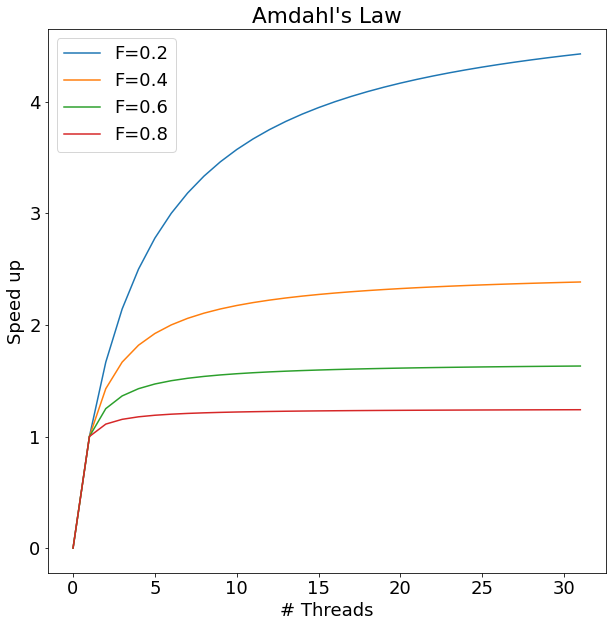

In [82]:
def amdahl(F, p):
    return 1 / (F + (1 - F) * (1 / p))

plt.rcParams['figure.figsize'] = [10, 10]

p = torch.from_numpy(np.array([_ for _ in range(32)]))
Fs = [0.2, 0.4, 0.6, 0.8]

for F in Fs:
    y = amdahl(F, p)
    plt.plot(p, y, label='F={}'.format(F))

plt.title("Amdahl's Law")
plt.xlabel("# Threads")
plt.ylabel("Speed up")
plt.legend()
plt.show()

## Overhead of threads: a glimpse of PARSEC 3.0

**Observation**: Theortically, there is a diminishing return. When `#threads` goes to infinity, the speed-up approximates `1/ F`.

However, in real-world scenerio, the overhead of multithreading pays an important role when `#threads` go to large.

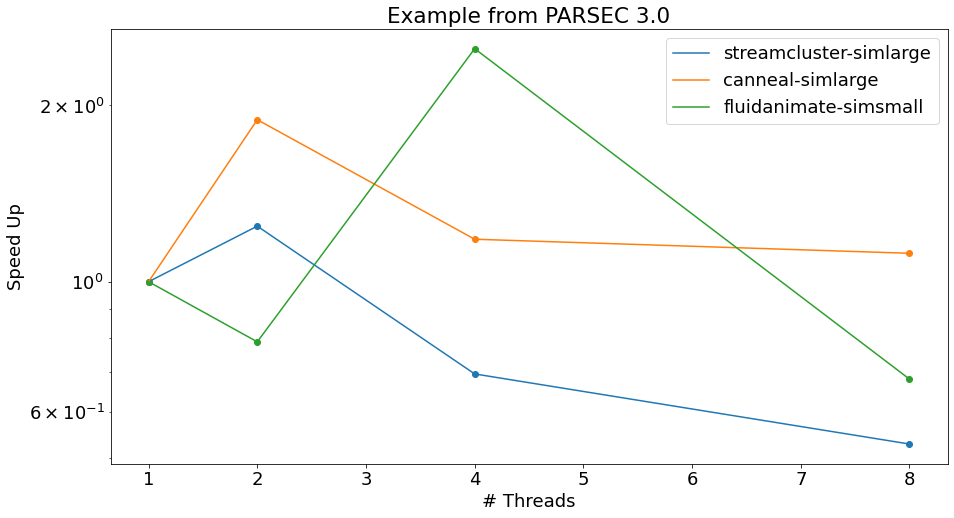

In [115]:
# load the data
csv_path = os.path.join("data", "dataset.csv")
df = pd.read_csv(csv_path)
dfname = df[['Name', 'Size']]

# pick columns of interest
Xdf = df[['total-instructions', 'L3-cache-misses', 'L1-data-cache-loads', 'branch-misses in %', 'L3-cache-references', 'Threads', 'IPC', 'branch-misses in %']]
ydf = df[['Speedup']]
Xlegend = dfname.to_numpy()[::4]

# convert to torch tensor to visualize
X = torch.from_numpy(Xdf.to_numpy())
y = torch.from_numpy(ydf.to_numpy())

X_enc = []
y_enc = []

for i in range(0, X.shape[0], 4):
    x_spl = X[i]
    y_spl = y[i: i + 4].view(4)
    
    X_enc.append(x_spl.numpy())
    y_enc.append(y_spl.numpy())
    
X = torch.from_numpy(np.array(X_enc))
y = torch.from_numpy(np.array(y_enc))

# plot the figure
ts = [1, 2, 4, 8]
idxs = [2, 11, 18]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for idx in idxs:
    ax.plot(ts, y[idx], label=Xlegend[idx, 0] + '-' + Xlegend[idx, 1])
    ax.scatter(ts, y[idx])

plt.rcParams['figure.figsize'] = [15, 8]
plt.title("Example from PARSEC 3.0")
ax.set_yscale('log')
plt.ylabel("Speed Up")
plt.xlabel("# Threads")
plt.legend()

**Insight**: There is a peek of performance at optimal configuration of `#threads`. It is also a very critical points when programmers deploy programs.

## Amdahl's plus formula

We introduce an extra term $o = (p - 1) \cdot \lambda \cdot T_{seq}$ at denominator to approximate overhead cost introduced by more threads, basing on assumptions:

- $o \propto p - 1$, cost of overhead increases when we introduce more threads.
- $o \propto T_{seq}$ more lengthy program requires more synchronization cost.

$$
    S(p; F, \lambda) = \frac{1}{F + (1 - F) / p + (p - 1) \cdot \lambda}
$$
where:
- $p\in \mathbb{Z^+}$ is number of process
- $F \in (0, 1)$ is fraction of sequential part of program
- $\lambda \in (0, +\infty)$ is coffcient to estimate overhead.

Try to solve the optimal solution for p

$$
    \frac{\partial S(p; F, \lambda)}{\partial p}= (-s^2)((F - 1) \cdot \frac{1}{p^2} + \lambda)
$$
optimal point $p^*$ should follows $\partial S / \partial p = 0$:
$$
    p = \sqrt{\frac{1-F}{\lambda}}
$$

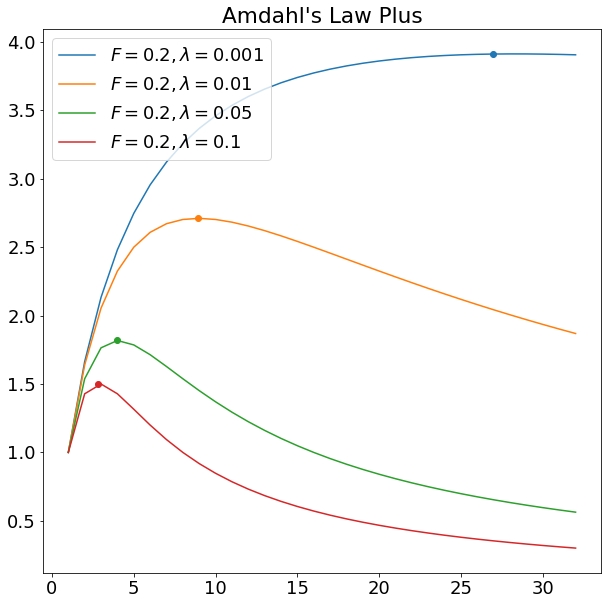

In [116]:
def amdahl_plus(F, lmd, p):
    return 1 / (F + (1 - F) * (1 / p) + (p - 1) * lmd)
def opt_p(F, lmd):
    ret = np.sqrt((1 - F) / (lmd + 1e-4))
    return np.clip(ret, a_min=1.0, a_max=32)

p = torch.from_numpy(np.array([_ for _ in range(1, 33)]))
lmds = [0.001, 0.01, 0.05, 0.1]

plt.rcParams['figure.figsize'] = [10, 10]

for lmd in lmds:
    y = amdahl_plus(F=0.2, lmd=lmd, p=p)
    
    plt.plot(p, y, label='$F=0.2, \lambda={}$'.format(lmd))
    p_ = opt_p(F=0.2, lmd=lmd)
    plt.scatter([p_], [amdahl_plus(F=0.2, lmd=lmd, p=p_)])

plt.title("Amdahl's Law Plus")
plt.legend()
plt.show()

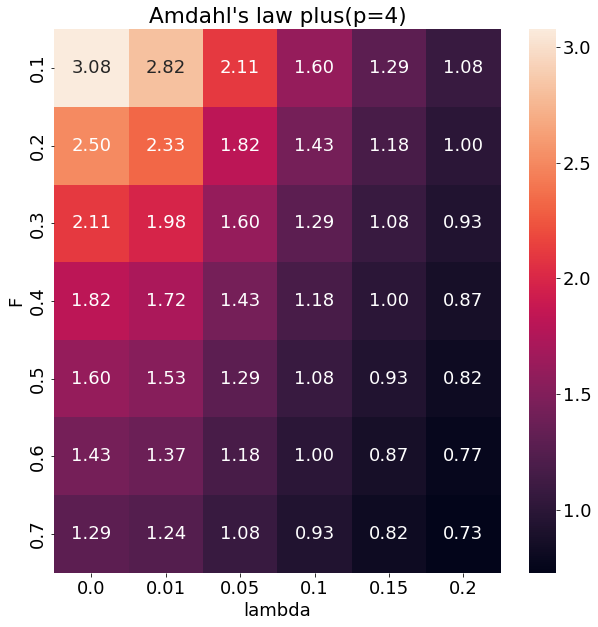

In [79]:
F = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]

out_f = []
out_l = []
out = []

df_data = []

for f in F:
    for l in L:
        df_data.append([f, l, amdahl_plus(F=f, lmd=l, p=4)])
df = pd.DataFrame(data=df_data, columns=['F', 'lambda', 'SpeedUp'])
    
vis = df.pivot('F', 'lambda', 'SpeedUp')
plt.title("Amdahl's law plus(p=4)")
ax = sns.heatmap(vis, annot=True, fmt=".2f")

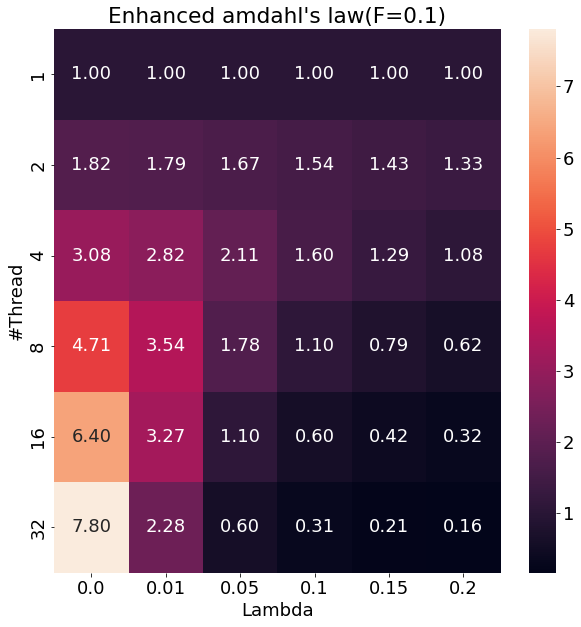

In [76]:
L = [0.0, 0.01, 0.05, 0.1, 0.15, 0.2]
P = [1, 2, 4, 8, 16, 32]

out_f = []
out_l = []
out = []

df_data = []

for l in L:
    for p in P:
        df_data.append([l, p, amdahl_plus(F=0.1, lmd=l, p=p)])
df = pd.DataFrame(data=df_data, columns=['Lambda', '#Thread', 'SpeedUp'])
    
vis = df.pivot('#Thread', 'Lambda', 'SpeedUp')
plt.title("Enhanced amdahl's law(F=0.1)")
ax = sns.heatmap(vis, annot=True, fmt=".2f")